In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tic_env import TictactoeEnv, OptimalPlayer
from performance_measures import M_opt, M_rand
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, display_png, Image
from tqdm.notebook import tqdm
from io import BytesIO
import imageio
plt.style

<module 'matplotlib.style' from '/Users/damiengomez/opt/anaconda3/lib/python3.8/site-packages/matplotlib/style/__init__.py'>

$M_opt$ measures the performance of $\pi$ against the optimal policy. <br>
To compute $M_{opt}$, we run $\pi$ against `Opt(0)` for `N = 500` games for different random seeds. <br>
$\pi$ makes the 1st move in 250 games, and `Opt(0)` makes the 1st move in the rest. <br>
We count how many games $\pi$ wins ($N_{win}$) and loses ($N_{loss}$) and define $$M_{opt} = \frac{N_{win} - N_{loss}}{N}$$.

$M_{rand}$ measures the performance of against the random policy. <br>
To compute $M_{rand}$, we repeat what we did for computing $M_{opt}$ but by using `Opt(1)` instead of `Opt(0)`.

In [3]:
p = OptimalPlayer(0)
print("M_opt: ", M_opt(p), ", M_rand: ", M_rand(p))

M_opt:  0.0 , M_rand:  0.926


## Q-Learning combined with epsilon-greedy policy. 

We start by creating a data structure to save our Q values

In [4]:
# stores only one value that it returns on any key
class FinalState():
    def __init__(self):
        self.value = 0
    def __getitem__(self, key):
        return self.value
    def __setitem__(self, key, value):
        self.value = value
    def values(self):
        return [self.value]
    def __repr__(self):
        return "{any: " + str(self.value) + "}"

# Q_table[state][move]
class QTable(dict):
    def __getitem__(self, key):
        self.__check_key(key)
        return super().__getitem__(self.__to_tuple(key))
    def __setitem__(self, key, value):
        self.__check_key(key)
        super().__setitem__(self.__to_tuple(key), value)

    def __missing__(self, key):
        arr = self.__to_array(key)
        non_zero_locations = list(zip(*np.nonzero(arr == 0)))
        if len(non_zero_locations) == 0:
            ret = self[arr] = FinalState()
            return ret
        ret = self[arr] = {loc: 0 for loc in non_zero_locations}
        return ret

    def __check_key(self, key):
        if not isinstance(key, np.ndarray):
            raise(TypeError("QTable only accepts np.ndarray of as keys"))
        if key.shape != (3, 3):
            raise(ValueError("QTable only accepts np.ndarray of shape (3, 3)"))
    def __to_array(self, key):
        if isinstance(key, tuple):
            key = np.array(key).reshape(3, 3)
        return key
    def __to_tuple(self, key):
        if isinstance(key, np.ndarray):
            key = tuple(key.reshape(-1))
        return key

In [5]:
f = FinalState()

At each time $t$, state $s_t$ is the board position, action $a_t$ is one of the available positions on the board and reward $r_t$. <br>
The reward only non-zero when the game ends where you get $r_t = 1$ if you win the game, $r_t = 1$ if you lose, and $r_t=0$ if it is a draw.

Q-Learning has 3 hyper-parameters: 
- learning rate $\alpha$
- discount factor $\gamma$
- and exploration level $\epsilon$ 

For convenience, we fix the learning rate at alpha = 0.05 and the discount factor at $\gamma$ = 0.99. <br>
We initialize all the Q-values at 0. <br>
If you are curious, you can explore the effect of $\alpha$, $\gamma$ and initial Q-values for yourself. <br>

In [6]:
alpha = 0.05 # learning rate 
gamma = 0.99 # discount factor
epsilon = 0 # exploration rate

### 2.2 Playing against itself

In [9]:
env = TictactoeEnv()
Q_table = QTable()
rewards = []
num_trained_episodes = 0
av_rewards = []

def epslion_greedy(state):
    Q_actions = Q_table[state]
    if np.random.random() < epsilon:
        actions = list(Q_actions.keys())
        if len(actions) == 1:
            return actions[0]
        return actions[np.random.randint(0, len(actions)-1)]
    else:
        return max(Q_actions, key=Q_actions.get)

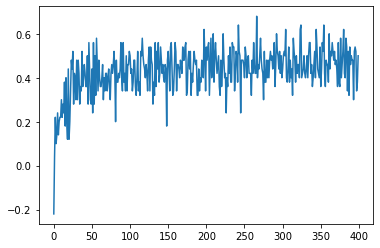

In [8]:
num_episodes = 20000

rewards_players1 = []
rewards_players2 = []

for itr in tqdm(range(num_episodes), desc="Q-learning"):
    env.reset()
    state0, end, _ = env.observe()

    first_play = True

    while not end:

        #X play (move 1)
        move1 = epsilon_greedy(state0)
        state1, end, _ = env.step(move1)

        #update Q according to O
        if(not first_play) : 
            Q_table[old_state1][old_move2] =    Q_table[old_state1][old_move2] + alpha * (reward + gamma * max(Q_table[state2].values()) -
                                                Q_table[old_state1][old_move2])

        #O play (move 2)
        move2 = epsilon_greedy(state1)
        state2, end, _ = env.step(move2)
        
        #update Q according to X
        Q_table[state0][move1] =    Q_table[state0][move1] + alpha * (reward + gamma * max(Q_table[state2].values()) - #attention
                                    Q_table[state0][move1])


        #if not end:
        #    next_move = epsilon_greedy(intermediate_state)
        #    next_state, end, _ = env.step(next_move)
        
        #reward = env.reward(player=learning_player1)  
            
        #if end:
        #    Q_table[next_state]["any"] = reward

        old_state1 = state1
        old_move2 = move2

        state0 = state2

        first_play = False

    rewards.append(reward)
    if len(rewards) >= 50:
        av_rewards.append(np.mean(rewards))
        rewards = []
        clear_output(wait=True)
        plt.plot(av_rewards)
        plt.show()
    num_trained_episodes += 1
    env.reset()

In [ ]:
num_episodes = 20000

rewards_players1 = []
rewards_players2 = []
av_rewards_player1 = []
av_rewards_player2 = []

for itr in tqdm(range(num_episodes), desc="Q-learning"):
    env.reset()
    state0, end, _ = env.observe()

    current_player = 'X'
    next_player = 'O'

    move1 = epsilon_greedy(state0) #move X
    state1, end, _ = env.step(move1)

    while not end:
        current_player, next_player = next_player, current_player

        move2 = epsilon_greedy(state1) #move O
        state2, end, _ = env.step(move2)
        reward = env.reward(player = next_player)

        Q_table[state0][move1] =    Q_table[state0][move1] + alpha * (reward + gamma * max(Q_table[state2].values()) -
                                    Q_table[state0][move1])

        state0 = state1
        state1 = state2
        move1 = move2

    reward = env.reward(player = current_player)
    Q_table[state1]["any"] = reward
    Q_table[state0][move1] =    Q_table[state0][move1] + alpha * (reward + gamma * max(Q_table[state1].values()) -
                                Q_table[state0][move1])
    

    rewards_players1.append(env.reward(player = 'X'))
    rewards_players2.append(env.reward(player = 'O'))
    if len(rewards_players1) >= 50:
        av_rewards_player1.append(np.mean(rewards_players1))
        av_rewards_player2.append(np.mean(rewards_players2))
        rewards_players1 = []
        rewards_players2 = []
        clear_output(wait=True)
        plt.subplot(1, 2, 1)
        plt.plot(av_rewards_player1)
        plt.subplot(1, 2, 2)
        plt.plot(av_rewards_player2)
        plt.show()
    num_trained_episodes += 1
    env.reset()